# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. 

In [2]:
# Standard library imports
import os
import random
import pandas as pd
import glob

# Third-party library imports
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from matplotlib.widgets import Slider
from ipywidgets import interact, interactive, fixed, interact_manual
from PIL import Image as IM
from PIL import Image
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.io import imread, imshow, concatenate_images
from scipy.ndimage import rotate, zoom
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# TensorFlow imports
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

# Keras imports
from keras import backend as K
from keras import layers
from keras.layers import *
from keras.models import *
from keras.applications.xception import Xception
from keras.models import load_model
from keras.optimizers import Adam, Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
# If one of the down two didn't work use the othre one
# from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import VGG16


# TensorFlow configuration
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-07-15 10:07:59.834146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 10:08:01.032197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-15 10:08:01.090410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-15 10:08:01.090575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here try to visualise the axial plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps.

In [3]:
# Data Visualization
# Choose set on the selection bar, then use the trackbar for moving up and down

# Messages
no_selection_hint = "Nothing Selected"

# Path related
img_path = 'dataset_segmentation/'
train_path = os.path.join(img_path, "train")

# Global variables
view_pla_path = None
view_seg_path = None
view_pla_load = None
view_seg_load = None
slices = None
sliders = None

# Function to update the displayed slice
def update_slice(val):
    global view_pla_load
    global view_seg_load
    imgfla = view_pla_load[:, :, val]
    imgseg = view_seg_load[:, :, val]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(imgfla, cmap='gray')
    plt.title('FLA')

    plt.subplot(1, 2, 2)
    plt.imshow(imgseg, cmap='gray')
    plt.title('SEG')
    plt.show()
    return

# Function to update the selected dataset
def update_set(strval):
    global view_pla_path
    global view_seg_path
    global view_pla_load
    global view_seg_load
    global slices
    global sliders
    
    try:
        if sliders is not None:
            sliders.close()
    except NameError:
        pass
    
    if strval['type'] == 'change' and strval['name'] == 'value':
        set_str = strval['new']
    
    if set_str == no_selection_hint:
        return
    
    view_pla_path = os.path.join(train_path, set_str, set_str + "_fla.nii.gz")
    view_seg_path = os.path.join(train_path, set_str, set_str + "_seg.nii.gz")

    view_pla_load = nib.load(view_pla_path).get_fdata()
    view_seg_load = nib.load(view_seg_path).get_fdata()

    slices = view_pla_load.shape
    sliders = widgets.interactive(update_slice, val=widgets.IntSlider(value=0, min=0, max=slices[2] - 1, step=1))
    display(sliders)
    return

# Get dataset subfolders
dataset_subfolder = []
for CLASS in os.listdir(train_path):
    if not CLASS.startswith('.'):
        dataset_subfolder.append(CLASS)

dataset_subfolder.sort()
dataset_subfolder.insert(0, no_selection_hint)

# Initialize dropdown widget
dropdown = widgets.Dropdown(options=dataset_subfolder, value=no_selection_hint, description='Data Select')

# Observe dropdown changes and call update_set function
dropdown.observe(update_set, names='value')

# Display the dropdown widget
display(dropdown)

Dropdown(description='Data Select', options=('Nothing Selected', '001', '002', '003', '004', '005', '006', '00…

## Data preprocessing (Optional)

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best segmentation result.


## Get the data generator ready

In [4]:
def flip_horizontal(image, mask):
    return np.fliplr(image), np.fliplr(mask)

def flip_vertical(image, mask):
    return np.flipud(image), np.flipud(mask)

def rotate_image(image, mask, angle):
    rotated_img = rotate(image, angle, reshape=False)
    rotated_mask = rotate(mask, angle, reshape=False)
    return rotated_img, rotated_mask

def shift_image_and_mask(image, mask, shift_x, shift_y):
    
    assert image.shape == mask.shape, "Image and mask must have the same shape"
    
    h, w = image.shape[:2]
    
    # Create empty arrays for the shifted image and mask
    shifted_image = np.zeros_like(image)
    shifted_mask = np.zeros_like(mask)
    
    # Define the ranges for the original and shifted image
    orig_x_min = max(0, -shift_x)
    orig_x_max = min(w, w - shift_x)
    orig_y_min = max(0, -shift_y)
    orig_y_max = min(h, h - shift_y)
    
    shifted_x_min = max(0, shift_x)
    shifted_x_max = min(w, w + shift_x)
    shifted_y_min = max(0, shift_y)
    shifted_y_max = min(h, h + shift_y)
    
    # Perform the shift
    shifted_image[shifted_y_min:shifted_y_max, shifted_x_min:shifted_x_max] = \
        image[orig_y_min:orig_y_max, orig_x_min:orig_x_max]
    
    shifted_mask[shifted_y_min:shifted_y_max, shifted_x_min:shifted_x_max] = \
        mask[orig_y_min:orig_y_max, orig_x_min:orig_x_max]
    
    return shifted_image, shifted_mask

def augment_data(img, msk, aug_dict):
    if aug_dict is not None:
    # for img, msk in zip(images, masks):
        # Apply horizontal flip
        if aug_dict.get('horizontal_flip', False) and np.random.rand() > 0.5:
            img, msk = flip_horizontal(img, msk)

        # Apply vertical flip
        if aug_dict.get('vertical_flip', False) and np.random.rand() > 0.5:
            img, msk = flip_vertical(img, msk)

        # Apply rotation
        if aug_dict.get('rotation_range', 0) > 0:
            angle = np.random.uniform(-aug_dict['rotation_range'], aug_dict['rotation_range'])
            img, msk = rotate_image(img, msk, angle)

        # Apply Shift
        if (aug_dict.get('width_shift_range', 0) > 0) & (aug_dict.get('height_shift_range', 0) > 0):
            shift_w = int(np.random.uniform(-aug_dict['width_shift_range'], aug_dict['width_shift_range']) * img.shape[0])
            shift_h = int(np.random.uniform(-aug_dict['height_shift_range'], aug_dict['height_shift_range']) * img.shape[0])
            img, msk = shift_image_and_mask(img, msk, shift_w, shift_h)
    return [img, msk] # return 3
    # print(f'Augmented Image shape: {img.shape}, Augmented Mask shape: {msk.shape}')



In [5]:

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, base_dir, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True, aug_dict = None):
        'Initialization'
        self.base_dir = base_dir
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.aug_dict = aug_dict
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            img = np.load(os.path.join(self.base_dir, 'image', ID))
            msk = np.load(os.path.join(self.base_dir, 'masks', ID))
            img, msk = augment_data(img, msk, self.aug_dict)
            # print(X.shape)
            # print(img.shape)
            X[i,...] = img
            y[i,...] = msk
        return X, y

### Split and Save

This code organizes and converts medical image data from the NIfTI format to the numpy format for further processing or analysis.

For validation data: The `npy_file` directory is set to `'Val'`.

For training data: The `npy_file` directory is set to `'Train'`.

Write to: The code writes the converted numpy files (`.npy`) to the following two subfolders within the `npy_file` directory:
- `'image'`: The converted image slices are saved in this subfolder.
- `'masks'`: The converted segmentation masks (if applicable) are saved in this subfolder.

In [10]:

def nii_to_npy(nii_pla_file, nii_seg_file, npy_file, idx):
    nii_img_pla = nib.load(nii_pla_file).get_fdata()
    nii_img_seg = nib.load(nii_seg_file).get_fdata()
    
    num_slices = nii_img_pla.shape[2]
    
    # Save each slice as a separate .npy file
    for i in range(num_slices):
        slice_data_pla = nii_img_pla[:, :, i]
        slice_data_seg = nii_img_seg[:, :, i]
        # if np.all(slice_data_pla == 0):
            # continue

        # slice_data_pla = np.repeat(slice_data_pla[:, :, np.newaxis], 3, axis=2)
        # slice_data_seg = np.repeat(slice_data_seg[:, :, np.newaxis], 3, axis=2) # channels = 3

        pla_file_slice = os.path.join(npy_file, 'image', idx + f'_slice_{i}.npy')
        seg_file_slice = os.path.join(npy_file, 'masks', idx + f'_slice_{i}.npy')
        slice_data_pla = slice_data_pla.astype(np.uint8)
        slice_data_seg = slice_data_seg.astype(np.uint8)
        np.save(pla_file_slice, slice_data_pla)
        np.save(seg_file_slice, slice_data_seg)
        # img_pla = IM.fromarray(slice_data_pla)
        # img_seg = IM.fromarray(slice_data_seg)
        # img_pla.save(pla_file_slice)
        # img_seg.save(seg_file_slice)
    return()

# path related
img_path = 'dataset_segmentation/'
train_path = os.path.join(img_path, "train")

dirs = os.listdir(train_path)
random.shuffle(dirs)

num = len(dirs)

for (n, file_name) in enumerate(dirs):
    if n < 0.8 * num:
        nii_file_pla = os.path.join(train_path, file_name, file_name + "_fla.nii.gz")
        nii_file_seg = os.path.join(train_path, file_name, file_name + "_seg.nii.gz")
        nii_to_npy(nii_file_pla, nii_file_seg, 'Train', file_name)
    else:
        nii_file_pla = os.path.join(train_path, file_name, file_name + "_fla.nii.gz")
        nii_file_seg = os.path.join(train_path, file_name, file_name + "_seg.nii.gz")
        nii_to_npy(nii_file_pla, nii_file_seg, 'Val', file_name)





Converting have been done successfully


## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

In [6]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

## UNet Class

The code defines a class called `UNet`, which encapsulates the U-Net model and its training process.

### Constructor (`__init__` method)

The constructor of the `UNet` class takes the following input parameters:

- `input_width` and `input_height`: The width and height of the input images.
- `num_classes`: The number of classes for the segmentation task.
- `train_images` and `train_instances`: Paths to the training images and their corresponding segmentation masks.
- `val_images` and `val_instances`: Paths to the validation images and their segmentation masks.
- `epochs`: The number of training epochs.
- `lr`: The learning rate for the optimizer.
- `lr_decay`: The learning rate decay factor.
- `batch_size`: The batch size used during training.
- `save_path`: The path to save the trained model.

### Methods

The `UNet` class defines two methods: `leftNetwork` and `rightNetwork`, which represent the left and right sides of the U-Net architecture, respectively.

#### `leftNetwork` method

The `leftNetwork` method takes an input tensor and performs a series of convolutional and pooling operations to extract features from the input image. It returns a list of feature maps at different resolutions.

#### `rightNetwork` method

The `rightNetwork` method takes the output of the `leftNetwork` method and performs a series of upsampling and concatenation operations to reconstruct the segmentation map. It combines the feature maps from the left side with the upsampled feature maps from the right side.

### TensorFlow Library

The code uses the TensorFlow library to define the U-Net model. It utilizes the following classes and functions:

- `tf.keras.layers.Conv2D`: Performs convolution operations.
- `tf.keras.layers.MaxPooling2D`: Performs max pooling.
- `tf.keras.layers.UpSampling2D`: Upsamples feature maps.
- `tf.keras.layers.Cropping2D`: Crops feature maps.
- `tf.keras.layers.concatenate`: Concatenates feature maps from different layers.


In [7]:
def unet(input_size=(240, 240, 1)):
    inputs = Input(input_size)

    # Encoder

    conv1 = Conv2D(filters=16, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=16, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    # Decoder
    up6 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=16, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=16, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])



## Train your model here
Once you defined the model and data generator, you can start training your model.

In [12]:
model = unet()
model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', dice_coef, iou_coef])

# with custom_object_scope({'iou_coef': iou_coef, 'dice_coef': dice_coef}):
#     model = load_model("model_right_5.h5")

model.summary()

epochs = 50
batch_size = 32
callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

train_pla_dir = os.path.join('Train', 'image')
valid_pla_dir = os.path.join('Val', 'image')

train_list = os.listdir(train_pla_dir)
valid_list = os.listdir(valid_pla_dir)

train_dir = 'Train/'
valid_dir = 'Val/'

tr_aug_dict = dict(rotation_range=180.0,
                    width_shift_range=0.5,
                    height_shift_range=0.5,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_generator = DataGenerator(train_dir, train_list, batch_size=batch_size, aug_dict=tr_aug_dict)
validation_generator = DataGenerator(valid_dir, valid_list, batch_size=batch_size)
img_size = (240,240)

history = model.fit(train_generator,
                    epochs=epochs,
                    # verbose=1,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    )

model.save("model_left_1.h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 240, 240, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 240, 240, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

2024-07-15 10:11:05.458783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-15 10:11:05.562339: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-07-15 10:11:05.563613: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-07-15 10:11:05.563626: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-07-15 10:11:05.563673: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 16/813 [..............................] - ETA: 3:54 - loss: 0.6728 - accuracy: 0.8193 - dice_coef: 0.0173 - iou_coef: 0.0088

KeyboardInterrupt: 

1/1 [==============================] - 0s 163ms/step


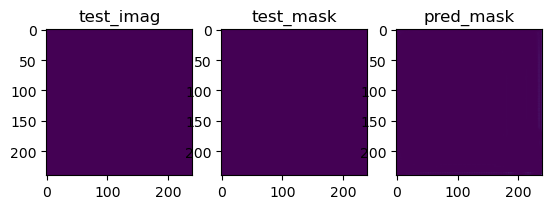

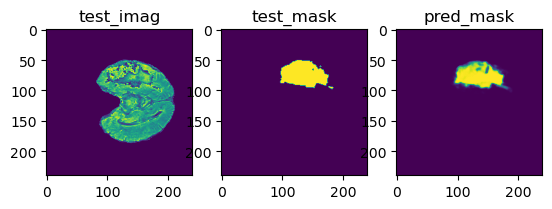

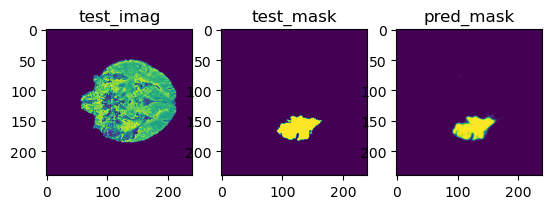

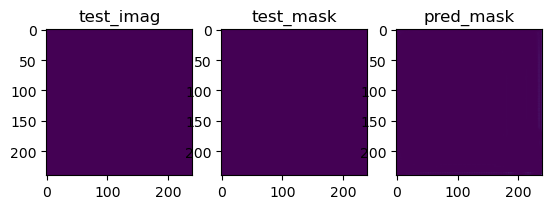

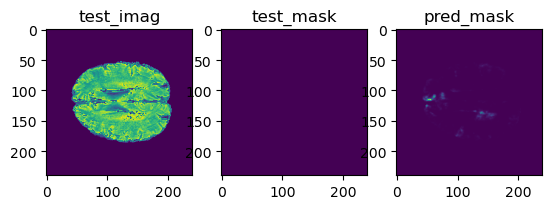

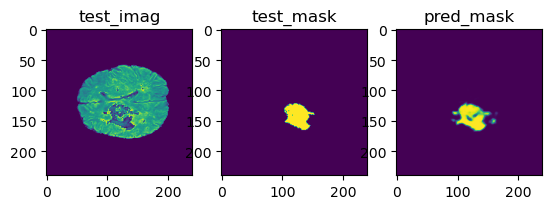

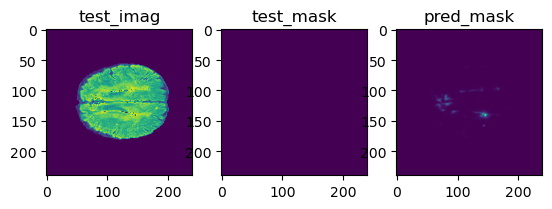

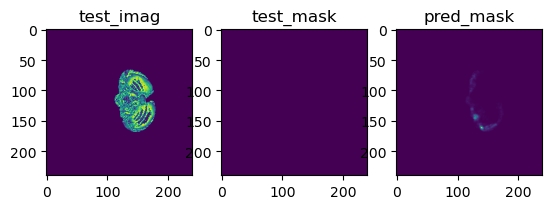

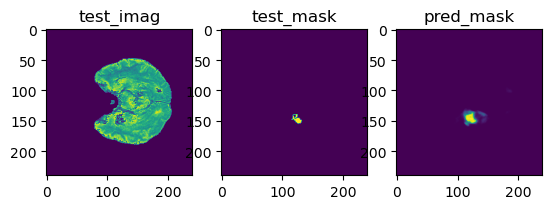

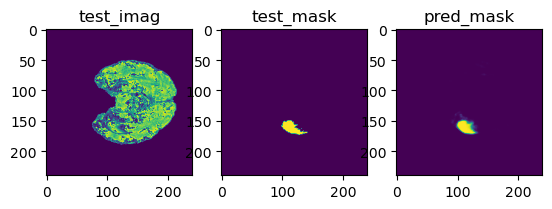

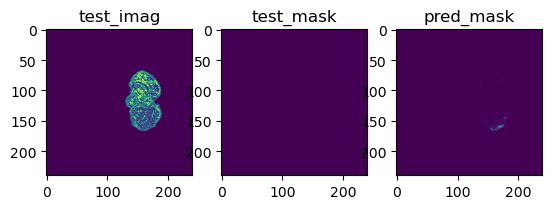

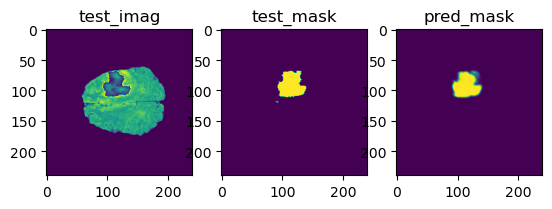

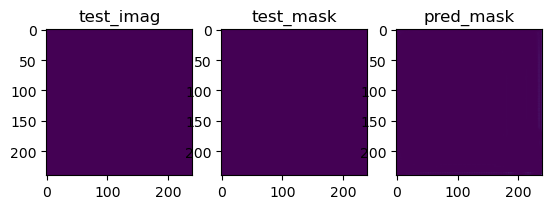

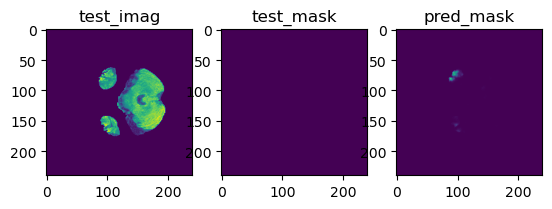

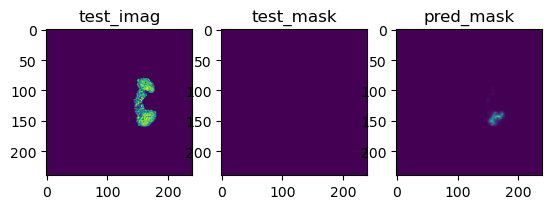

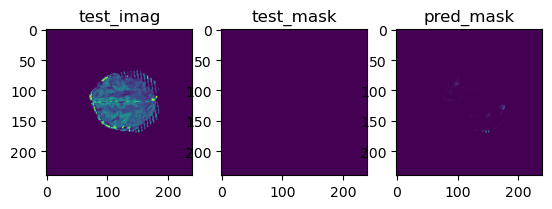

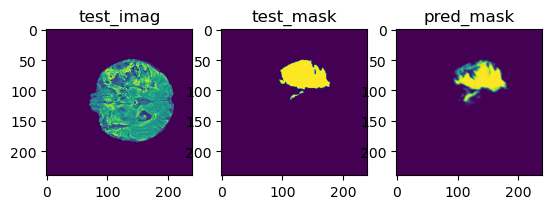

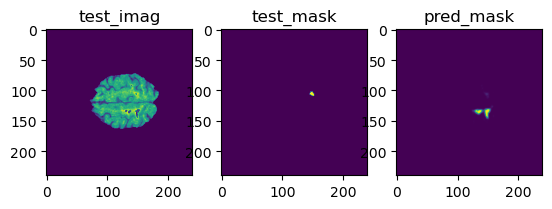

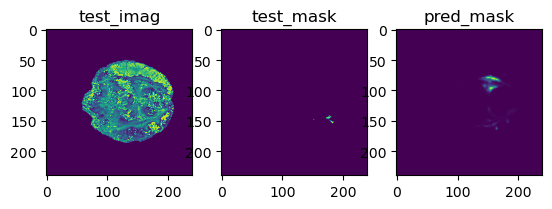

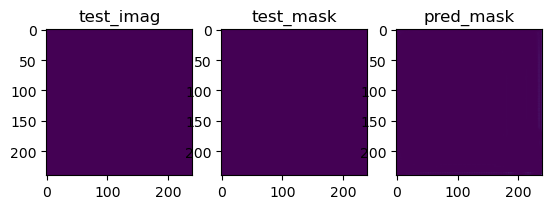

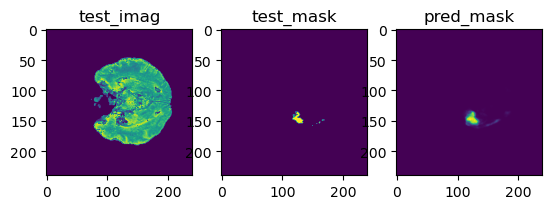

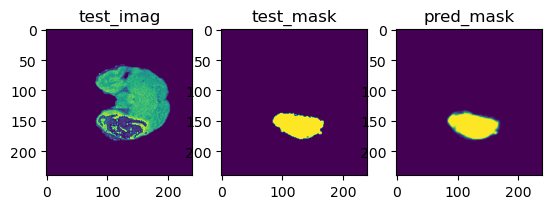

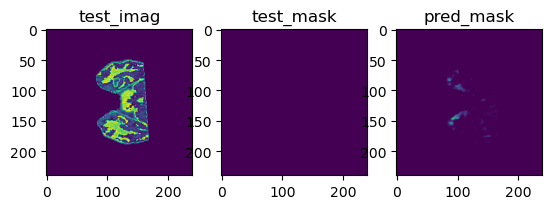

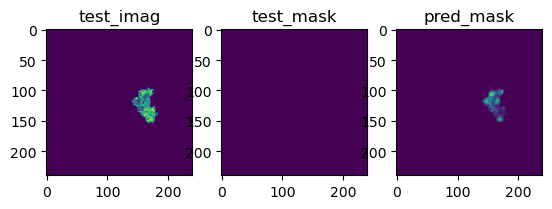

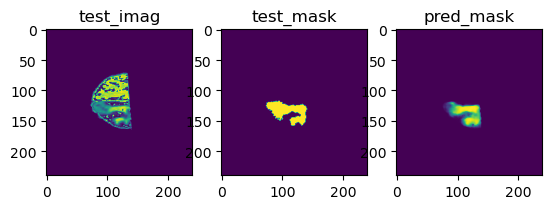

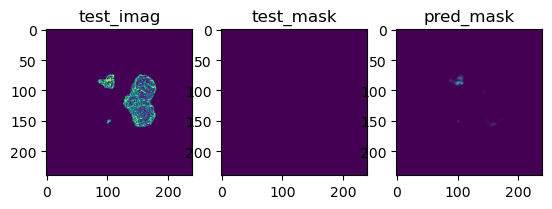

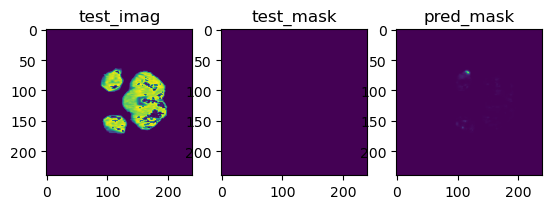

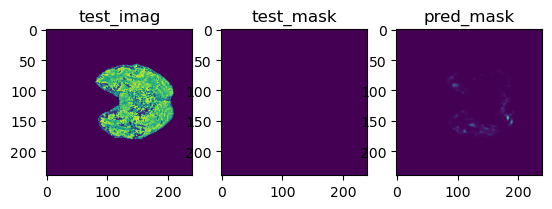

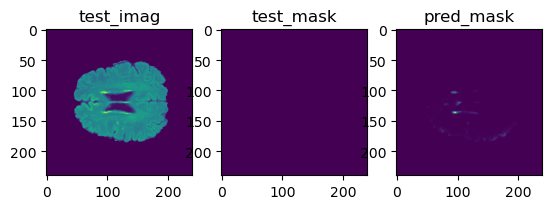

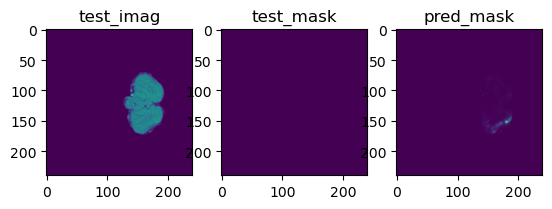

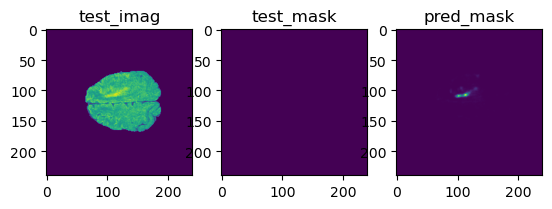

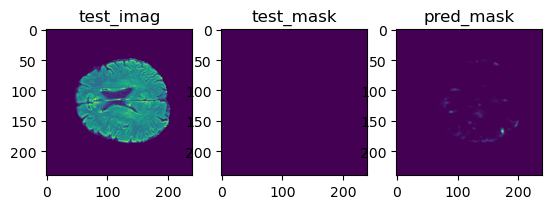

In [13]:

batch_size = 32

valid_pla_dir = os.path.join('Val', 'image')

valid_list = os.listdir(valid_pla_dir)

valid_dir = 'Val/'

model_path = "model_right_6.h5" 

with custom_object_scope({'iou_coef': iou_coef, 'dice_coef': dice_coef}):
    model = load_model(model_path)

validation_generator = DataGenerator(valid_dir, valid_list, batch_size=batch_size)

test_sets, test_masks = validation_generator.__getitem__(3)

preds = model.predict(test_sets)

for i in range(batch_size):
    test_imag = test_sets[i]
    test_mask = test_masks[i]
    pred_mask = preds[i]

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(test_imag)
    plt.title("test_imag")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask)
    plt.title("test_mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("pred_mask")

    plt.show()

## Save the model
Once your model is trained, remember to save it for testing.

## Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_fla.nii.gz', save your segmentation result as '100_seg.nii.gz'. 